In [1]:
import tensorflow as tf
import numpy as np
from generate_tfio_dataset import generate_datasets
from auxiliar import get_time_stamp
import keras
from keras import layers, Model, Input, models
from train_models import load_from_weights
from build_model import ABlock, BBlock, CBlock
from generate_datasets import evaluate_model_on_test_set
import matplotlib.pyplot as plt
import keras_tuner as kt

2024-06-01 17:37:25.903572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 17:37:27.804192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 17:37:27.809205: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 17:37:27.809247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUM

In [2]:
batch_size = 64
epochs = 20
ibcnn_filepath = 'ibcnn_best.keras'
sbcnn_filepath = 'sbcnn_best.keras'

In [3]:
train_ds, val_ds = generate_datasets(batch_size=batch_size)

2024-06-01 17:37:28.067613: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-06-01 17:37:28.071748: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


In [4]:
class Distiller(Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [5]:
# for the teacher, lets load our trained ibcnn model

teacher = load_from_weights(ibcnn_filepath) # loading a pretrained model `amc.ipynb`
# using only model weihts, but this keras file has the hole model saved
# could just use standar load_model and avoid warnings

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 218 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [6]:
# now, lets build a student

# for test, we chose to build a sbcnn based student,
# composed with only one a-type block, a GAP layer
# and a dense layer for classification
class StudentSBCNN(layers.Layer):
    def __init__(self):
        super().__init__()
        self.a_block = ABlock()
        # self.b_block = BBlock()
        # self.c_block = CBlock()
        # self.flatten = layers.Flatten()
        self.gavg_pool = layers.GlobalAveragePooling2D()
        self.dense_layer = layers.Dense(24)  # hard-coded

    def __call__(self, inputs, **kwargs):
        x = self.a_block(inputs, **kwargs)
        # x = self.b_block(x, **kwargs)
        # x = self.c_block(x, **kwargs)
        x = self.gavg_pool(x)
        x = self.dense_layer(x)
        return x
    
def build_student_model():
    input_signal = Input((2, 1024, 1))
    output_logit = StudentSBCNN()(input_signal)
    model = Model(input_signal, output_logit, name = "student")
    return model

# student = build_student_model()

In [7]:
# checkout the student's size
# it is much smoller then the standard sbcnn model
# student.summary()

In [8]:
# clone student for later comparison
# student_scratch = models.clone_model(student)
# student_scratch.name = 'student_scratch'

In [8]:
def build_model(hp):
    alpha = hp.Float(
    "alpha_factor",
    min_value=0,
    max_value=1)

    temp = hp.Float(
    "temperature",
    min_value=1,
    max_value=10,)

    student = build_student_model()

    distiller = Distiller(student=student,
                      teacher=teacher)

    distiller.compile(
    optimizer=keras.optimizers.AdamW(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=alpha,
    temperature=temp,
    )

    return distiller

In [9]:
tuner = kt.Hyperband(build_model,
                     objective='val_sparse_categorical_accuracy',
                     max_epochs=40,
                     factor=4,
                     directory='amr_dir',
                     project_name='student_optimization')


In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5)

In [ ]:
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Trial 4 Complete [00h 14m 24s]
val_sparse_categorical_accuracy: 0.6505365371704102

Best val_sparse_categorical_accuracy So Far: 0.7184868454933167
Total elapsed time: 00h 56m 42s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
0.18331           |0.019345          |alpha_factor
2.3153            |1.7448            |temperature
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3


2024-06-01 18:35:06.071539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 90246 of 177012
2024-06-01 18:35:16.137460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 162826 of 177012
2024-06-01 18:35:17.780619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 286s 23ms/step - sparse_categorical_accuracy: 0.6316 - distillation_loss: 2.3968 - loss: -5.4492 - student_loss: 0.8373 - val_loss: -10.2160 - val_sparse_categorical_accuracy: 0.6436
Epoch 2/3


2024-06-01 18:39:47.906466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 116738 of 177012


    3/11064 ━━━━━━━━━━━━━━━━━━━━ 4:47 26ms/step - sparse_categorical_accuracy: 0.2908 - distillation_loss: 9.1613 - loss: -9.0343 - student_loss: 3.1268    

2024-06-01 18:39:56.059713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 272s 23ms/step - sparse_categorical_accuracy: 0.7554 - distillation_loss: 1.3648 - loss: -8.5038 - student_loss: 0.6738 - val_loss: -8.6141 - val_sparse_categorical_accuracy: 0.6633
Epoch 3/3


2024-06-01 18:44:19.486815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 60419 of 177012
2024-06-01 18:44:32.131714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


 4560/11064 ━━━━━━━━━━━━━━━━━━━━ 52:21 483ms/step - sparse_categorical_accuracy: 0.8360 - distillation_loss: 1.0769 - loss: -6.8030 - student_loss: 0.5263

In [ ]:

best_model = tuner.get_best_models()[0]


In [10]:
# distill teacher to student

name = 'student'

callbacks = [
        # tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=name + '_best.keras',
            save_weights_only=False,
            monitor='val_sparse_categorical_accuracy',
            mode='max',
            save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
        tf.keras.callbacks.CSVLogger(name + f'{get_time_stamp()}log.csv', separator=",", append=True),
        keras.callbacks.EarlyStopping(patience=epochs,
                                      monitor='val_sparse_categorical_accuracy',
                                      restore_best_weights=True)
    ]

distiller.fit(
    train_ds, 
    epochs=epochs,
    shuffle=True,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:587: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
2024-05-30 22:02:21.368811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 113653 of 177012
2024-05-30 22:02:28.308089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1717106548.315317     129 service.cc:145] XLA service 0xeab4040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717106548.315393     129 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-30 22:02:28.498703: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set e

    1/11064 ━━━━━━━━━━━━━━━━━━━━ 87:35:14 29s/step - sparse_categorical_accuracy: 0.0000e+00 - distillation_loss: 3.1467 - loss: 0.1138 - student_loss: 3.3527

I0000 00:00:1717106556.560309     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - sparse_categorical_accuracy: 0.6623 - distillation_loss: 0.5085 - loss: -2.2027 - student_loss: 0.8190

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - sparse_categorical_accuracy: 0.6623 - distillation_loss: 0.5085 - loss: -2.2028 - student_loss: 0.8190 - val_loss: -4.5641 - val_sparse_categorical_accuracy: 0.6765
Epoch 2/20


2024-05-30 22:06:47.503428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 79881 of 177012
2024-05-30 22:06:57.612014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 155651 of 177012
2024-05-30 22:06:59.979570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 254s 21ms/step - sparse_categorical_accuracy: 0.7777 - distillation_loss: 0.3151 - loss: -4.1243 - student_loss: 0.6246 - val_loss: -4.7965 - val_sparse_categorical_accuracy: 0.7191
Epoch 3/20


2024-05-30 22:11:01.022030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 82970 of 177012
2024-05-30 22:11:11.135020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 152584 of 177012
2024-05-30 22:11:13.157203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 257s 21ms/step - sparse_categorical_accuracy: 0.7946 - distillation_loss: 0.2799 - loss: -4.1774 - student_loss: 0.5878 - val_loss: -4.1990 - val_sparse_categorical_accuracy: 0.7262
Epoch 4/20


2024-05-30 22:15:18.088271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 72708 of 177012
2024-05-30 22:15:31.484341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 258s 21ms/step - sparse_categorical_accuracy: 0.8007 - distillation_loss: 0.2616 - loss: -3.7316 - student_loss: 0.5684 - val_loss: -3.5516 - val_sparse_categorical_accuracy: 0.7375
Epoch 5/20


2024-05-30 22:19:35.768367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 89086 of 177012
2024-05-30 22:19:45.895366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 161787 of 177012
2024-05-30 22:19:48.416443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 260s 21ms/step - sparse_categorical_accuracy: 0.8079 - distillation_loss: 0.2473 - loss: -3.2558 - student_loss: 0.5542 - val_loss: -3.0982 - val_sparse_categorical_accuracy: 0.7224
Epoch 6/20


2024-05-30 22:23:55.425207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 79887 of 177012
2024-05-30 22:24:05.525542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 150529 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 74:39:02 24s/step - sparse_categorical_accuracy: 0.5938 - distillation_loss: 1.5962 - loss: -2.7810 - student_loss: 1.6565

2024-05-30 22:24:09.424423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 262s 21ms/step - sparse_categorical_accuracy: 0.8153 - distillation_loss: 0.2361 - loss: -2.8383 - student_loss: 0.5425 - val_loss: -2.7109 - val_sparse_categorical_accuracy: 0.7457
Epoch 7/20


2024-05-30 22:28:17.552452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 87041 of 177012
2024-05-30 22:28:30.013860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 260s 21ms/step - sparse_categorical_accuracy: 0.8234 - distillation_loss: 0.2257 - loss: -2.5545 - student_loss: 0.5315 - val_loss: -2.1324 - val_sparse_categorical_accuracy: 0.7575
Epoch 8/20


2024-05-30 22:32:37.147954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 72708 of 177012
2024-05-30 22:32:51.148614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 262s 22ms/step - sparse_categorical_accuracy: 0.8305 - distillation_loss: 0.2160 - loss: -2.0561 - student_loss: 0.5210 - val_loss: -1.8008 - val_sparse_categorical_accuracy: 0.7626
Epoch 9/20


2024-05-30 22:36:59.502937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 88832 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 75:55:48 25s/step - sparse_categorical_accuracy: 0.6406 - distillation_loss: 0.8614 - loss: -1.5062 - student_loss: 0.9258

2024-05-30 22:37:13.994806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 260s 21ms/step - sparse_categorical_accuracy: 0.8347 - distillation_loss: 0.2093 - loss: -1.5977 - student_loss: 0.5138 - val_loss: -1.1126 - val_sparse_categorical_accuracy: 0.7608
Epoch 10/20


2024-05-30 22:41:19.444058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 80902 of 177012
2024-05-30 22:41:29.446491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 157698 of 177012
2024-05-30 22:41:32.641050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 254s 21ms/step - sparse_categorical_accuracy: 0.8363 - distillation_loss: 0.2044 - loss: -1.1187 - student_loss: 0.5085 - val_loss: -0.7029 - val_sparse_categorical_accuracy: 0.7727
Epoch 11/20


2024-05-30 22:45:33.224615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 89415 of 177012
2024-05-30 22:45:43.351536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 158721 of 177012
2024-05-30 22:45:45.381700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 250s 21ms/step - sparse_categorical_accuracy: 0.8390 - distillation_loss: 0.1999 - loss: -0.7035 - student_loss: 0.5034 - val_loss: -0.2840 - val_sparse_categorical_accuracy: 0.7561
Epoch 12/20


2024-05-30 22:49:42.972739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 86048 of 177012
2024-05-30 22:49:54.532857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 248s 20ms/step - sparse_categorical_accuracy: 0.8402 - distillation_loss: 0.1967 - loss: -0.3817 - student_loss: 0.5002 - val_loss: 0.1216 - val_sparse_categorical_accuracy: 0.7753
Epoch 13/20


2024-05-30 22:53:51.063445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 88888 of 177012
2024-05-30 22:54:01.058841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 152103 of 177012
2024-05-30 22:54:05.022395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 252s 21ms/step - sparse_categorical_accuracy: 0.8410 - distillation_loss: 0.1940 - loss: -0.0675 - student_loss: 0.4973 - val_loss: 0.3467 - val_sparse_categorical_accuracy: 0.7673
Epoch 14/20


2024-05-30 22:58:03.367608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 90730 of 177012
2024-05-30 22:58:13.418635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 166914 of 177012
2024-05-30 22:58:14.706515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 247s 20ms/step - sparse_categorical_accuracy: 0.8419 - distillation_loss: 0.1908 - loss: 0.1665 - student_loss: 0.4938 - val_loss: 0.5684 - val_sparse_categorical_accuracy: 0.7658
Epoch 15/20


2024-05-30 23:02:10.705508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 88065 of 177012
2024-05-30 23:02:21.864066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 247s 20ms/step - sparse_categorical_accuracy: 0.8434 - distillation_loss: 0.1888 - loss: 0.4062 - student_loss: 0.4910 - val_loss: 0.7117 - val_sparse_categorical_accuracy: 0.7680
Epoch 16/20


2024-05-30 23:06:17.964570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 84993 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 67:54:57 22s/step - sparse_categorical_accuracy: 0.8125 - distillation_loss: 0.4204 - loss: 0.8115 - student_loss: 0.4760

2024-05-30 23:06:29.704006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 246s 20ms/step - sparse_categorical_accuracy: 0.8436 - distillation_loss: 0.1871 - loss: 0.5800 - student_loss: 0.4896 - val_loss: 1.2221 - val_sparse_categorical_accuracy: 0.7622
Epoch 17/20


2024-05-30 23:10:24.162160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 89129 of 177012
2024-05-30 23:10:34.301544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 165890 of 177012
2024-05-30 23:10:35.242179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 257s 21ms/step - sparse_categorical_accuracy: 0.8463 - distillation_loss: 0.1845 - loss: 0.7533 - student_loss: 0.4871 - val_loss: 1.0142 - val_sparse_categorical_accuracy: 0.7606
Epoch 18/20


2024-05-30 23:14:40.855367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 82940 of 177012
2024-05-30 23:14:51.015210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 164873 of 177012
2024-05-30 23:14:52.838338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 250s 21ms/step - sparse_categorical_accuracy: 0.8451 - distillation_loss: 0.1823 - loss: 0.9363 - student_loss: 0.4851 - val_loss: 1.1786 - val_sparse_categorical_accuracy: 0.7883
Epoch 19/20


2024-05-30 23:18:50.694758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 77342 of 177012
2024-05-30 23:19:00.784369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 156691 of 177012
2024-05-30 23:19:03.534691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 261s 22ms/step - sparse_categorical_accuracy: 0.8461 - distillation_loss: 0.1817 - loss: 0.9729 - student_loss: 0.4834 - val_loss: 1.1838 - val_sparse_categorical_accuracy: 0.7858
Epoch 20/20


2024-05-30 23:23:12.090846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 78851 of 177012
2024-05-30 23:23:22.223736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 159747 of 177012
2024-05-30 23:23:24.340689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 254s 21ms/step - sparse_categorical_accuracy: 0.8471 - distillation_loss: 0.1796 - loss: 1.0565 - student_loss: 0.4812 - val_loss: 1.2080 - val_sparse_categorical_accuracy: 0.7874


In [11]:
# compile student so it can be evaluated....
# evaluate_model_on_test_set expect a compiled model
student.compile(
        optimizer=keras.optimizers.AdamW(),  # Optimizer
        # Loss function to minimize
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        # List of metrics to monitor
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
student.save('student_best.keras')

In [12]:
student_score = evaluate_model_on_test_set(student)

db: 16
file: radiodataset0to16/Test/16/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1144 - sparse_categorical_accuracy: 0.9641
score: 0.9220660328865051
db: 4
file: radiodataset0to16/Test/4/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5406 - sparse_categorical_accuracy: 0.7841
score: 0.7073146104812622
db: 12
file: radiodataset0to16/Test/12/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1155 - sparse_categorical_accuracy: 0.9635
score: 0.9158516526222229
db: 14
file: radiodataset0to16/Test/14/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1156 - sparse_categorical_accuracy: 0.9644
score: 0.9187041521072388
db: 6
file: radiodataset0to16/Test/6/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3192 - sparse_categorical_accuracy: 0.8577
score: 0.7937041521072388
db: 10
file: radiodataset0to16/Test/10/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1392 - sparse_categorical_accuracy: 0.949

In [13]:
student_scratch.compile(
    optimizer=keras.optimizers.AdamW(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [14]:
# Train and evaluate student trained from scratch.
name = 'student_scratch'

callbacks = [
        # tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=name + '_best.keras',
            save_weights_only=False,
            monitor='val_sparse_categorical_accuracy',
            mode='max',
            save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
        tf.keras.callbacks.CSVLogger(name + f'{get_time_stamp()}log.csv', separator=",", append=True),
        keras.callbacks.EarlyStopping(patience=epochs,
                                      monitor='val_sparse_categorical_accuracy',
                                      restore_best_weights=True)
    ]

student_scratch.fit(train_ds, epochs=20, shuffle=True, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20


2024-05-30 23:27:50.729748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 81825 of 177012
2024-05-30 23:28:00.819274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 157695 of 177012
2024-05-30 23:28:03.100340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 203s 16ms/step - loss: 0.8877 - sparse_categorical_accuracy: 0.6539 - val_loss: 0.8126 - val_sparse_categorical_accuracy: 0.6681
Epoch 2/20


2024-05-30 23:31:10.429905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 86020 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 68:59:29 22s/step - loss: 2.7404 - sparse_categorical_accuracy: 0.2188

2024-05-30 23:31:22.569007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 185s 15ms/step - loss: 0.5250 - sparse_categorical_accuracy: 0.7736 - val_loss: 0.7512 - val_sparse_categorical_accuracy: 0.6891
Epoch 3/20


2024-05-30 23:34:15.565163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 84993 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 68:08:48 22s/step - loss: 1.7388 - sparse_categorical_accuracy: 0.4062

2024-05-30 23:34:27.390972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 185s 15ms/step - loss: 0.4781 - sparse_categorical_accuracy: 0.7903 - val_loss: 0.6403 - val_sparse_categorical_accuracy: 0.7306
Epoch 4/20


2024-05-30 23:37:20.446411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 96274 of 177012
2024-05-30 23:37:30.534605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 165884 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 65:50:15 21s/step - loss: 1.7167 - sparse_categorical_accuracy: 0.4688

2024-05-30 23:37:31.671612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 186s 15ms/step - loss: 0.4559 - sparse_categorical_accuracy: 0.7993 - val_loss: 0.6515 - val_sparse_categorical_accuracy: 0.7256
Epoch 5/20


2024-05-30 23:40:26.841109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 84995 of 177012
2024-05-30 23:40:36.918584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 161793 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 68:42:50 22s/step - loss: 1.6032 - sparse_categorical_accuracy: 0.5156

2024-05-30 23:40:38.975154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 188s 15ms/step - loss: 0.4428 - sparse_categorical_accuracy: 0.8060 - val_loss: 0.6222 - val_sparse_categorical_accuracy: 0.7373
Epoch 6/20


2024-05-30 23:43:35.228384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 84988 of 177012
2024-05-30 23:43:45.245243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 158721 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 70:02:39 23s/step - loss: 1.4886 - sparse_categorical_accuracy: 0.5156

2024-05-30 23:43:47.839543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 193s 15ms/step - loss: 0.4332 - sparse_categorical_accuracy: 0.8130 - val_loss: 0.6276 - val_sparse_categorical_accuracy: 0.7349
Epoch 7/20


2024-05-30 23:46:48.012583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 90115 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 72:13:44 24s/step - loss: 2.6207 - sparse_categorical_accuracy: 0.3906

2024-05-30 23:47:01.102425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 194s 15ms/step - loss: 0.4258 - sparse_categorical_accuracy: 0.8188 - val_loss: 0.5830 - val_sparse_categorical_accuracy: 0.7601
Epoch 8/20


2024-05-30 23:50:01.861482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 85135 of 177012
2024-05-30 23:50:12.004578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 155650 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 73:10:15 24s/step - loss: 0.7730 - sparse_categorical_accuracy: 0.7031

2024-05-30 23:50:15.491712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 194s 15ms/step - loss: 0.4134 - sparse_categorical_accuracy: 0.8252 - val_loss: 0.6334 - val_sparse_categorical_accuracy: 0.7447
Epoch 9/20


2024-05-30 23:53:16.008748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 84994 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 74:05:33 24s/step - loss: 1.2044 - sparse_categorical_accuracy: 0.6250

2024-05-30 23:53:29.795665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 193s 15ms/step - loss: 0.4057 - sparse_categorical_accuracy: 0.8291 - val_loss: 0.6002 - val_sparse_categorical_accuracy: 0.7520
Epoch 10/20


2024-05-30 23:56:28.821974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 84314 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 67:16:06 22s/step - loss: 1.3105 - sparse_categorical_accuracy: 0.6250

2024-05-30 23:56:40.529381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 193s 15ms/step - loss: 0.3998 - sparse_categorical_accuracy: 0.8323 - val_loss: 0.7296 - val_sparse_categorical_accuracy: 0.7160
Epoch 11/20


2024-05-30 23:59:41.656175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 82961 of 177012
2024-05-30 23:59:51.748633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 156673 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 72:29:06 24s/step - loss: 1.1254 - sparse_categorical_accuracy: 0.5938

2024-05-30 23:59:54.994563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 198s 16ms/step - loss: 0.3926 - sparse_categorical_accuracy: 0.8354 - val_loss: 0.5646 - val_sparse_categorical_accuracy: 0.7732
Epoch 12/20


2024-05-31 00:02:59.181333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 85191 of 177012
2024-05-31 00:03:09.180284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 159747 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 67:50:31 22s/step - loss: 0.6865 - sparse_categorical_accuracy: 0.7344

2024-05-31 00:03:11.066854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 193s 15ms/step - loss: 0.3881 - sparse_categorical_accuracy: 0.8373 - val_loss: 0.5499 - val_sparse_categorical_accuracy: 0.7780
Epoch 13/20


2024-05-31 00:06:12.041801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 86017 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 67:49:17 22s/step - loss: 1.8607 - sparse_categorical_accuracy: 0.4844

2024-05-31 00:06:23.775629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 189s 15ms/step - loss: 0.3879 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.5854 - val_sparse_categorical_accuracy: 0.7570
Epoch 14/20


2024-05-31 00:09:21.486540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 87031 of 177012
2024-05-31 00:09:31.508925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 164866 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 68:35:25 22s/step - loss: 1.3646 - sparse_categorical_accuracy: 0.5469

2024-05-31 00:09:33.423490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 203s 16ms/step - loss: 0.3824 - sparse_categorical_accuracy: 0.8405 - val_loss: 0.5542 - val_sparse_categorical_accuracy: 0.7773
Epoch 15/20


2024-05-31 00:12:43.948091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 86019 of 177012
2024-05-31 00:12:54.027043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 166914 of 177012


    1/11064 ━━━━━━━━━━━━━━━━━━━━ 66:48:38 22s/step - loss: 1.3962 - sparse_categorical_accuracy: 0.6406

2024-05-31 00:12:55.468011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 187s 15ms/step - loss: 0.3803 - sparse_categorical_accuracy: 0.8405 - val_loss: 0.5442 - val_sparse_categorical_accuracy: 0.7735
Epoch 16/20


2024-05-31 00:15:50.992514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 88067 of 177012
2024-05-31 00:16:01.018120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 162817 of 177012
2024-05-31 00:16:03.183224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 187s 15ms/step - loss: 0.3768 - sparse_categorical_accuracy: 0.8416 - val_loss: 0.5506 - val_sparse_categorical_accuracy: 0.7778
Epoch 17/20


2024-05-31 00:18:58.030195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 87041 of 177012
2024-05-31 00:19:08.081964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 159753 of 177012
2024-05-31 00:19:10.083966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 184s 15ms/step - loss: 0.3730 - sparse_categorical_accuracy: 0.8439 - val_loss: 0.5478 - val_sparse_categorical_accuracy: 0.7753
Epoch 18/20


2024-05-31 00:22:02.598347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 82948 of 177012
2024-05-31 00:22:13.351144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 185s 15ms/step - loss: 0.3760 - sparse_categorical_accuracy: 0.8424 - val_loss: 0.5623 - val_sparse_categorical_accuracy: 0.7702
Epoch 19/20


2024-05-31 00:25:07.566445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 78815 of 177012
2024-05-31 00:25:17.675418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 160769 of 177012
2024-05-31 00:25:19.568921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 183s 15ms/step - loss: 0.3724 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.5446 - val_sparse_categorical_accuracy: 0.7714
Epoch 20/20


2024-05-31 00:28:10.932631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 88067 of 177012
2024-05-31 00:28:21.716784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


11064/11064 ━━━━━━━━━━━━━━━━━━━━ 184s 15ms/step - loss: 0.3714 - sparse_categorical_accuracy: 0.8440 - val_loss: 0.5769 - val_sparse_categorical_accuracy: 0.7545


In [15]:
student_scratch.save('student_scratch.keras')

In [16]:
student_scratch_score = evaluate_model_on_test_set(student_scratch)

db: 16
file: radiodataset0to16/Test/16/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.9441
score: 0.893541157245636
db: 4
file: radiodataset0to16/Test/4/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5212 - sparse_categorical_accuracy: 0.7808
score: 0.6992664933204651
db: 12
file: radiodataset0to16/Test/12/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1542 - sparse_categorical_accuracy: 0.9442
score: 0.8891605734825134
db: 14
file: radiodataset0to16/Test/14/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.9404
score: 0.8835574388504028
db: 6
file: radiodataset0to16/Test/6/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3161 - sparse_categorical_accuracy: 0.8742
score: 0.7980847358703613
db: 10
file: radiodataset0to16/Test/10/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1711 - sparse_categorical_accuracy: 0.9361

In [17]:
teacher_score = evaluate_model_on_test_set(teacher)

db: 16
file: radiodataset0to16/Test/16/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0318 - sparse_categorical_accuracy: 0.9883
score: 0.9608802199363708
db: 4
file: radiodataset0to16/Test/4/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3263 - sparse_categorical_accuracy: 0.8508
score: 0.7813773155212402
db: 12
file: radiodataset0to16/Test/12/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0342 - sparse_categorical_accuracy: 0.9874
score: 0.9562958478927612
db: 14
file: radiodataset0to16/Test/14/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9870
score: 0.9548696279525757
db: 6
file: radiodataset0to16/Test/6/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1609 - sparse_categorical_accuracy: 0.9291
score: 0.8791768550872803
db: 10
file: radiodataset0to16/Test/10/test_data.h5
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0461 - sparse_categorical_accuracy: 0.98

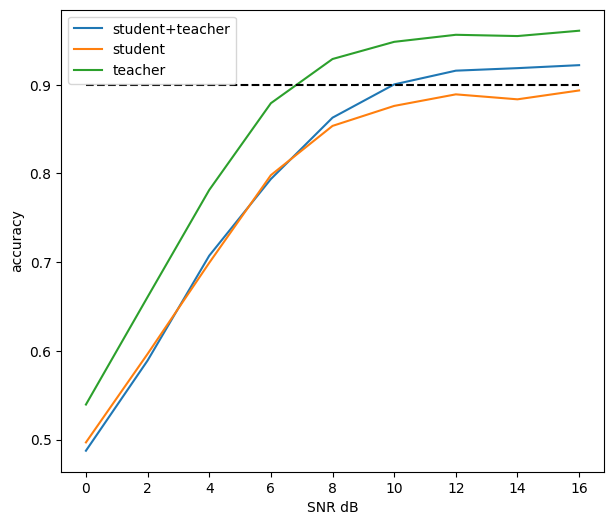

In [18]:
snr_db = teacher_score.keys()
plt.figure(figsize=(7, 6))
plt.plot(snr_db, student_score.values(), label='student+teacher')
plt.plot(snr_db, student_scratch_score.values(), label='student')
plt.plot(snr_db, teacher_score.values(), label='teacher')
plt.plot([0.9]*17, 'k--')
plt.legend()
plt.xlabel('SNR dB')
plt.ylabel('accuracy')
plt.savefig('knowledge_distillation_v3.png')
plt.show()